# Simulation of Contrast Transfer Function

In [1]:
import numpy as np
import cv2 as cv
from numpy.fft import *
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

## Fourier Transfer Part

In [22]:
img = cv.imread('img/bacteria1.jpg', 0) # 转为灰度图处理
#进行傅立叶变换
fft2_image = np.fft.fft2(img)
#将图像变换的原点移动到频域矩形的中心
shift2center = np.fft.fftshift(fft2_image)
disp_img = 20 * np.log(np.abs(shift2center))

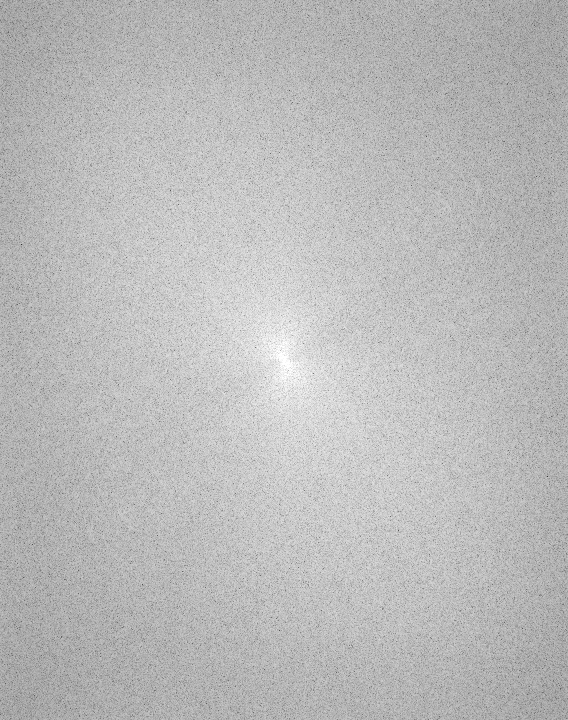

In [24]:
cv2_imshow(disp_img)

## CTF Part

* 已知:&emsp;图像的傅里叶变换 = 对象的傅里叶变换 × CTF, *i.e.*</br>
$$ \mathscr{F}\left\{Image\right\} = \mathscr{F}\left\{Object\right\}*CTF $$


所以, 我们给图像加上CTF噪声直接对傅里叶变换得到的频域图像乘上CTF.</br>
现在, 我们考虑CTF的形式: </br>

$$ CTF = sin(-\pi\Delta{z}\lambda{k}^2 + \frac{\pi{C_s}{\lambda}^3{k}^4}{2}) $$

此外, 还有极坐标下的形式:

$$ CTF = sin(\frac{-πzθ^2}{λ} + \frac{πC_sθ^4}{2λ})) $$


参数说明:

| param   | description           |   value   |
| ---- | -------------- | ---- |
| Δz   | 散焦           |   -45.5Å   |
| λ    | 放射波波长     |   1.97 pm(300keV)   |
| k    | 空间频率       | θ=λk |
| Cs   | 物镜的球差系数 |   7μm   |
| θ |  透射电子波之间的散射角  |0~2π|

* [Scherzer defocus](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy#Scherzer_defocus)</br>

散焦通过球差和加速电压(通过波长)给出:

$$ \Delta{f_{Scherzer}} = -1.2\sqrt{C_s\lambda} $$

1.2定义了扩展的Scherzer散焦. 对于NCEM的CM300, 球差=0.6mm 加速电压=300keV (波长=1.97 pm), 可以得到ΔfScherzer=-41.25 nm.

In [65]:
# 获取波长, 通过加速电压给出
def energy2wavelength(energy: float) -> float:
  return 12.2643247 / np.sqrt(energy * (1 + energy * 0.978466e-6)) * 1e-10

# 获取散焦, 通过给定的球差系数和电子能量给出, 采用Scherzer defocus
def getDefocus(Cs, energy):
  return 1.2 * np.sqrt(Cs * energy2wavelength(energy))

In [66]:
# 初始化系数
Cs = 7e-6 # 球差系数 7μm
energy = 300e3 # 加速电压300kV
wavelength = energy2wavelength(energy) # 波长
defocus = getDefocus(Cs, energy) # 散焦
lambda3wave = np.power(wavelength, 3) # 波长三次方
B_factor = 50 # 指定envelope函数值

In [96]:
scattered_angle = np.arange(0, 2*np.pi, 0.001)
k = scattered_angle / wavelength
power2k = k ** 2 # 空间频率平方
power4k = power2k ** 2 # 空间频率四次幂

In [115]:
def ctfObtainment():
  ctf = np.sin(-np.pi * defocus * wavelength * power2k + np.pi * Cs * lambda3wave * power4k / 2)
  return ctf

In [111]:
ctf = ctfObtainment()

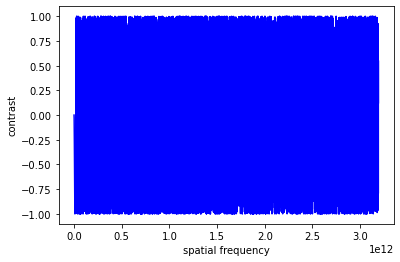

In [112]:
plt.xlabel("spatial frequency")
plt.ylabel("contrast")
plt.plot(k, ctf, "blue")

* 模拟衰减

In [113]:
E = np.exp(-1 * 5*1e-25 * power2k)
Y = ctf * E

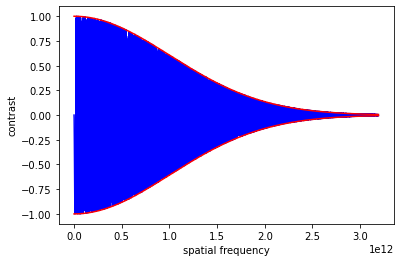

In [114]:
plt.xlabel("spatial frequency")
plt.ylabel("contrast")
plt.plot(k, Y, "blue")
plt.plot(k, E, color="red")
plt.plot(k, -E, color="red")

## Image Processing Part